# 日历效应策略

一个特别简单的投资策略，策略：每个月的前五个交易日满仓沪深 300 指数，其他日子都空仓。

关于这个策略的可能的逻辑猜想（月末银行和散户资金流吃紧，月初流动性增强）：
- 国内银行每个月月底会归拢资金或者核账，所以导致月底钱比较紧，但下个月初又会把钱放出来，这就形成月初的资金流动性比平时好；
- 大多数人每月底领到工资，月初就可以定投出去了。可能是因为这两个因素，形成了一个有规律的月初买入资金流。
>对于这两点假设，无法通过回测来完全证实。

In [1]:
import pandas as pd

策略逻辑

In [2]:
# %run ./shared/tools.py
# %run ./shared/calendar_strategy.py

from shared.tools import SymbolCategry
from shared.calendar_strategy import get_widgets, load_hist_data, run_strategy, backtest_result

设置回测参数

In [3]:
# 交易手续费
fee_rate_fund = 0.0015
fee_rate_stock = 0.00025

In [4]:
ui, datePickers, dayRange, symbols = get_widgets()
ui

In [5]:
# 回测起止日期
start_date = datePickers[0].value
end_date = datePickers[1].value

# 每月持仓交易起始日、截止日。从1起
day_range = [dayRange[0].value,dayRange[1].value]

加载回测数据

In [6]:
index_data = load_hist_data('main-indices-data')
# index_data = pd.read_csv('../res/指数历史数据.csv').set_index('datetime')
# index_data.index = [datestr2dtdate(e) for e in index_data.index]

index_ids = ['hs300', 'csi500', 'csi1000']

回测

读懂回测结果：

- AnnRet 表示年化收益，AnnVol 表示年化波动率，SR 表示夏普率，MaxDD 表示最大回撤，Calmar 表示年化收益与最大回撤的比值，TotalRet 表示总收益；
- 蓝色线 asset 代表投资标的，橙色线 stgy 代表策略，pos 代表仓位。

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index -0.022992  0.202433 -0.113576 -0.395856 -0.058081 -0.067580
stgy   0.140543  0.110278  1.274444 -0.121568  1.156087  0.485275


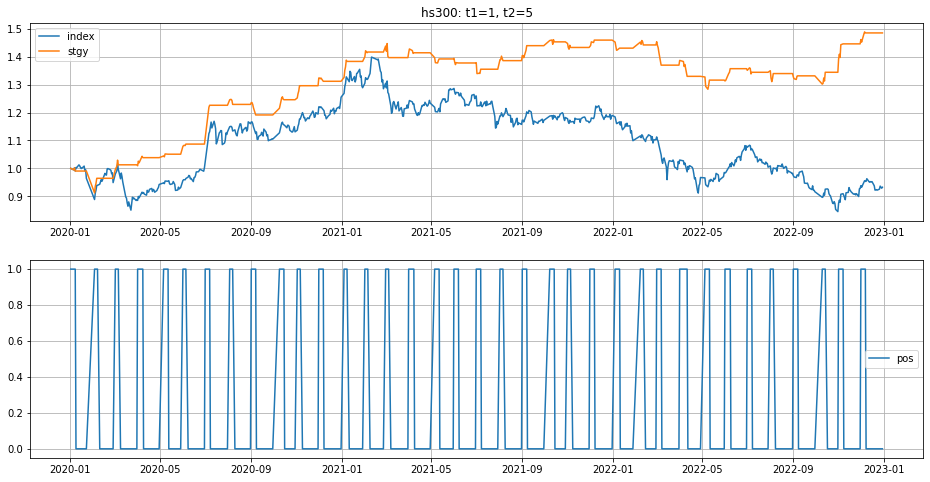

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index   0.02996  0.209771  0.142822 -0.315704  0.094898  0.092866
stgy   0.174715  0.108314   1.61304 -0.106446  1.641359  0.623215


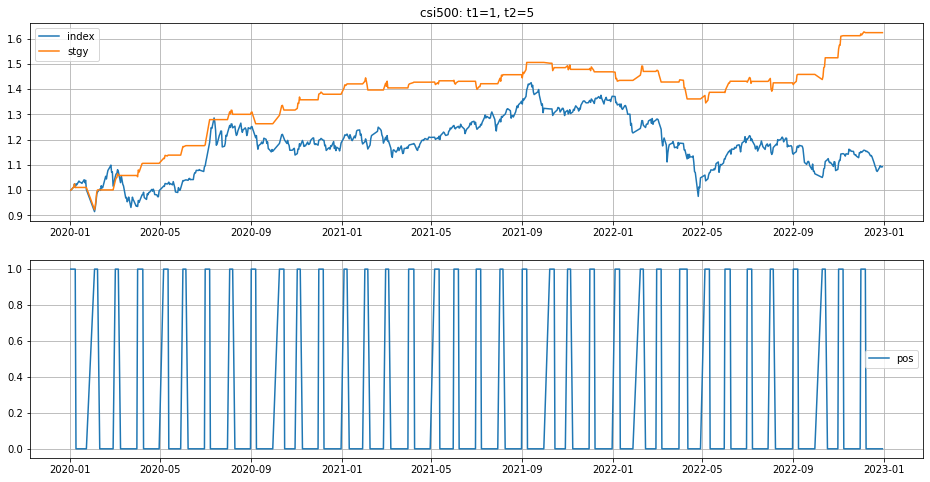

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index  0.034241  0.237132  0.144397 -0.346243  0.098894  0.106589
stgy   0.164648  0.120982  1.360926 -0.171917  0.957715  0.581725


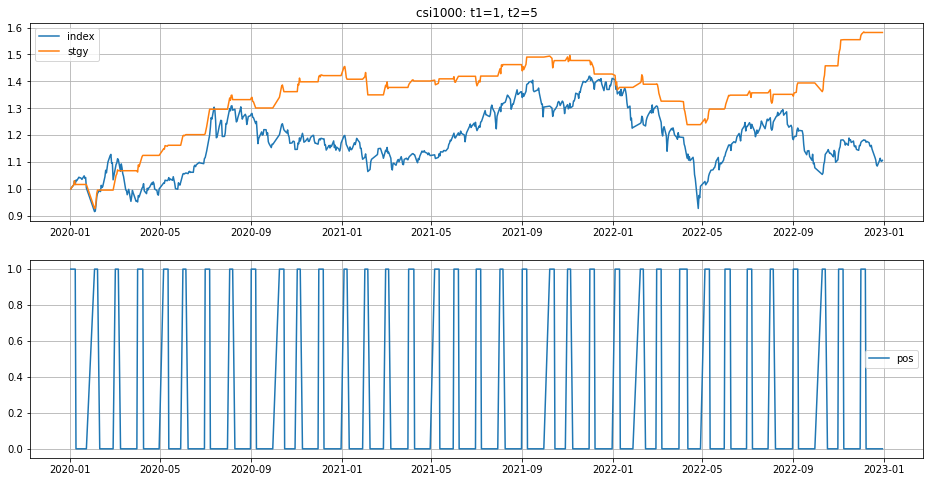

In [7]:
# 沪深 300
data = pd.DataFrame(data=0, index=index_data.index, columns=['hs300'])
data['hs300'] = index_data['hs300']
df = run_strategy(data, index_ids[0], start_date, end_date, day_range, fee_rate_stock)
backtest_result(df, title=f'{index_ids[0]}: t1={day_range[0]}, t2={day_range[1]}')

# 中证 500
df = run_strategy(index_data, index_ids[1], start_date, end_date, day_range, fee_rate_stock)
backtest_result(df, title=f'{index_ids[1]}: t1={day_range[0]}, t2={day_range[1]}')

# 中证 1000
df = run_strategy(index_data, index_ids[2], start_date, end_date, day_range, fee_rate_stock)
backtest_result(df, title=f'{index_ids[2]}: t1={day_range[0]}, t2={day_range[1]}')

<hr />

In [8]:
def backtest(symbol_id, col_mappings, folder, params):
    start_date = params['start_date']
    end_date = params['end_date']
    day_range = params['day_range']
    fee = params['fee']

    df = load_hist_data(symbol_id, col_mappings, folder)
    df = run_strategy(df, symbol_id, start_date, end_date, day_range, fee)
    backtest_result(df, title=f'{symbol_id}: t1={day_range[0]}, t2={day_range[1]}')

<hr />

## 沪深 300 替代方案

In [9]:
ui_large, datePickers_large, dayRange_large, symbols_large = get_widgets(symbol_type=SymbolCategry.LargeCap)
ui_large

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index -0.022992  0.202433 -0.113576 -0.395856 -0.058081 -0.067580
stgy   0.140543  0.110278  1.274444 -0.121568  1.156087  0.485275


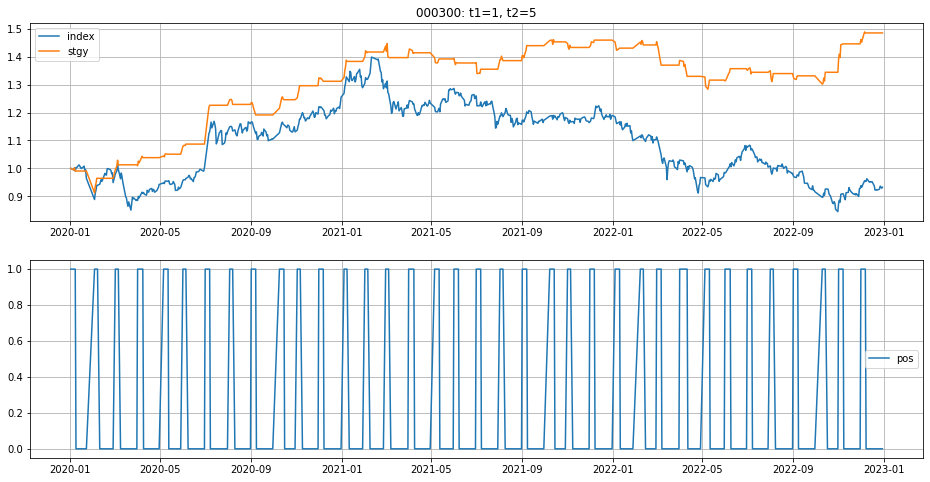

In [10]:
symbol_id = symbols_large[0].value
params = dict({
    'start_date': datePickers_large[0].value,
    'end_date': datePickers_large[1].value,
    'day_range': [dayRange_large[0].value, dayRange_large[1].value],
})

is_fund = symbols_large[1].value
if is_fund:
    params['fee'] = fee_rate_fund
    col_mapping = {'nav': symbol_id}
else:
    params['fee'] = fee_rate_stock
    col_mapping = {'close': symbol_id}

backtest(symbol_id, col_mapping, '../res/large/', params)

<hr />

## 中证 500 替代方案

In [11]:
ui_small, datePickers_small, dayRange_small, symbols_small = get_widgets(symbol_type=SymbolCategry.SmallCap)
ui_small

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index   0.02996  0.209771  0.142822 -0.315704  0.094898  0.092866
stgy   0.174715  0.108314   1.61304 -0.106446  1.641359  0.623215


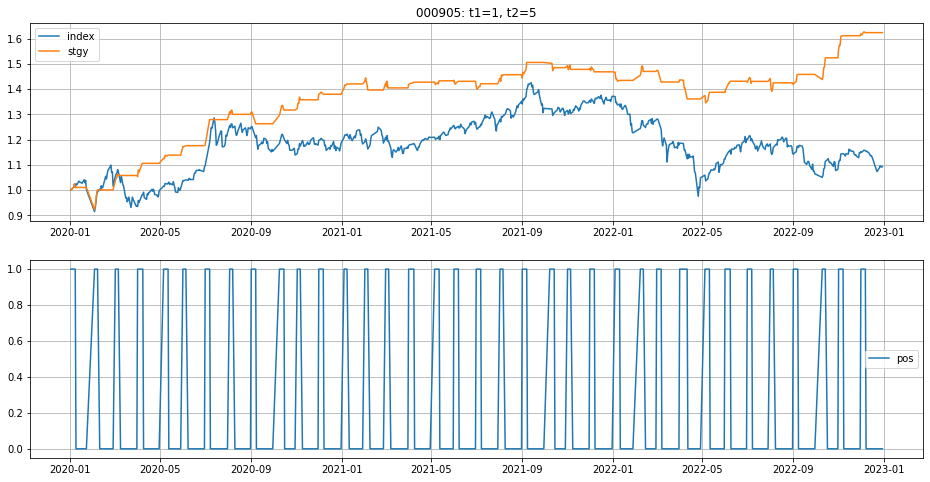

In [12]:
symbol_id = symbols_small[0].value
params = dict({
    'start_date': datePickers_small[0].value,
    'end_date': datePickers_small[1].value,
    'day_range': [dayRange_small[0].value, dayRange_small[1].value],
})

is_fund = symbols_small[1].value
if is_fund:
    params['fee'] = fee_rate_fund
    col_mapping = {'nav': symbol_id}
else:
    params['fee'] = fee_rate_stock
    col_mapping = {'close': symbol_id}

backtest(symbol_id, col_mapping, '../res/small', params)


<hr />

## 红利

In [13]:
ui_div, datePickers_div, dayRange_div, symbols_div = get_widgets(symbol_type=SymbolCategry.Divident)
ui_div

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index  0.014547   0.19167  0.075894 -0.175402  0.082933  0.044278
stgy   0.150232  0.105892  1.418733 -0.095722  1.569457  0.521797


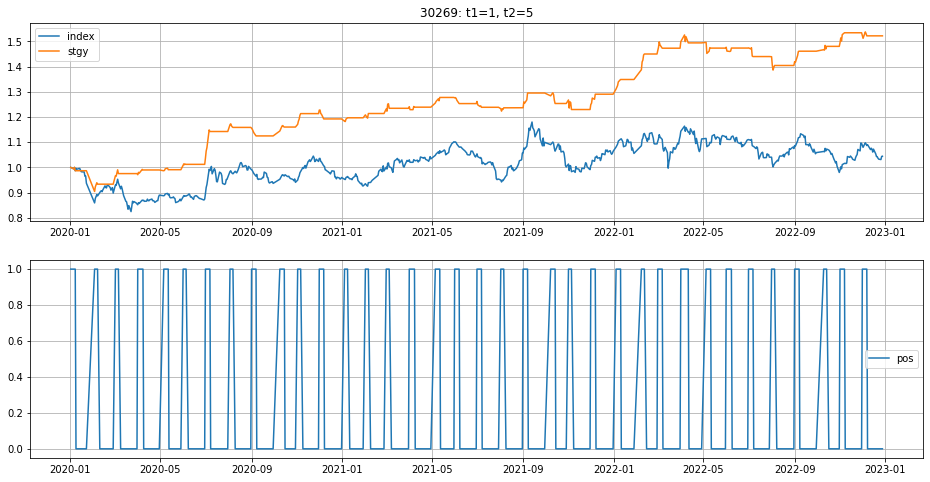

In [14]:
symbol_id = symbols_div[0].value
params = dict({
    'start_date': datePickers_div[0].value,
    'end_date': datePickers_div[1].value,
    'day_range': [dayRange_div[0].value, dayRange_div[1].value],
})

is_fund = symbols_div[1].value
if is_fund:
    params['fee'] = fee_rate_fund
    col_mapping = {'nav': symbol_id}
else:
    params['fee'] = fee_rate_stock
    col_mapping = {'close': symbol_id}

backtest(symbol_id, col_mapping, '../res/div', params)

<hr />

## 行业

In [15]:
ui_spec, datePickers_spec, dayRange_spec, symbols_spec = get_widgets(symbol_type=SymbolCategry.Specialization)
ui_spec

         AnnRet    AnnVol        SR     MaxDD    Calmar  TotalRet
index  0.013912  0.253023  0.054983 -0.454796   0.03059  0.042438
stgy   0.124938  0.126878  0.984708 -0.165154  0.756494  0.424978


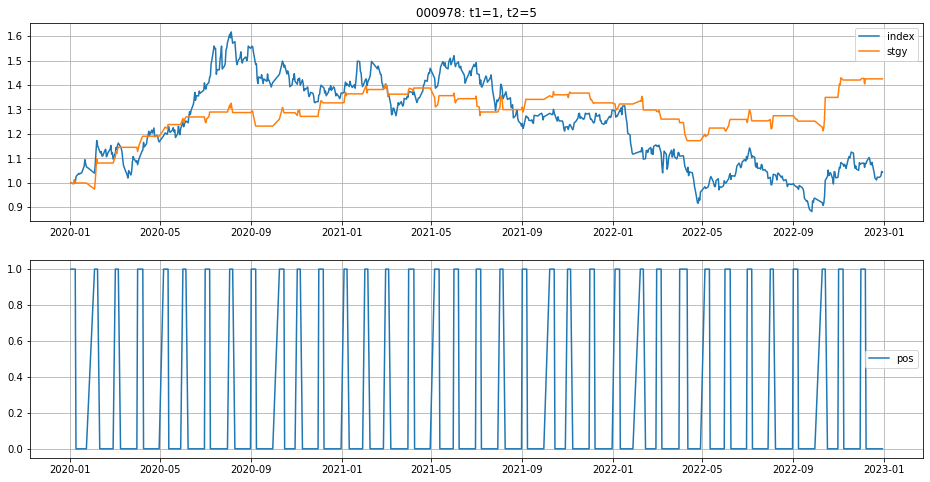

In [16]:
symbol_id = symbols_spec[0].value
params = dict({
    'start_date': datePickers_spec[0].value,
    'end_date': datePickers_spec[1].value,
    'day_range': [dayRange_spec[0].value, dayRange_spec[1].value],
})

is_fund = symbols_spec[1].value
if is_fund:
    params['fee'] = fee_rate_stock
    col_mapping = {'nav': symbol_id}
else:
    params['fee'] = fee_rate_stock
    col_mapping = {'close': symbol_id}

backtest(symbol_id, col_mapping, '../res/specialization', params)